In [29]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import tensorflow as tf
sess = tf.InteractiveSession()

We start building the computation graph by creating nodes for the input images and target output classes.

In [14]:
x = tf.placeholder(tf.float32, shape=[None, 784]) # x will be a 2d numpy array with axis 1 of dimension 784,
                                                  # axis 0 is the batch size
y_ = tf.placeholder(tf.float32, shape=[None, 10]) # y_ will have axis 1 consisting of zeros and a single 1
                                                  # corresponding to the correct class

Here x and y_ aren't specific values. Rather, they are each a placeholder -- a value that we'll input when we ask TensorFlow to run a computation.

In [15]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

Before Variables can be used within a session, they must be initialized using that session. This step takes the initial values (in this case tensors full of zeros) that have already been specified, and assigns them to each Variable

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
y = tf.matmul(x,W) + b

Define the cost function, softmax maps y to the probability of each class

In [19]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))

In [22]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [23]:
for i in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})


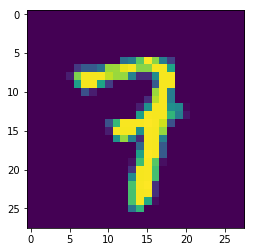

In [35]:
plt.imshow(batch[0][0].reshape(28, 28))

In [48]:
# to see what happens at an intermediate computation one
# can do sess.run(command, feed_dict={necessary input})
sess.run(tf.nn.softmax_cross_entropy_with_logits(y, y_), 
         feed_dict={x: batch[0], y_: batch[1]}).shape

(100,)


How well did our model do?

First we'll figure out where we predicted the correct label. tf.argmax is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, tf.argmax(y,1) is the label our model thinks is most likely for each input, while tf.argmax(y_,1) is the true label. We can use tf.equal to check if our prediction matches the truth.

In [49]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, [True, False, True, True] would become [1,0,1,1] which would become 0.75.

In [50]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [52]:
# accuracy is evaluated on a test set

In [53]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9181


# Building a convolutional neural net

Getting 92% accuracy on MNIST is bad. It's almost embarrassingly bad. In this section, we'll fix that, jumping from a very simple model to something moderately sophisticated: a small convolutional neural network. This will get us to around 99.2% accuracy -- not state of the art, but respectable.

Assign random numbers of weights and biases.

In [54]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

## Convolution and Pooling

TensorFlow also gives us a lot of flexibility in convolution and pooling operations. How do we handle the boundaries? What is our stride size? In this example, we're always going to choose the vanilla version. Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. Our pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, let's also abstract those operations into functions.

I will explain what the next functions are doing.

In [56]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


## First Convolutional Layer

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [61]:
W_conv1 = weight_variable([5, 5, 1, 32]) 
b_conv1 = bias_variable([32])

In [62]:
x_image = tf.reshape(x, [-1,28,28,1])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [63]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [64]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [70]:
W_fc1 = weight_variable([7 * 7 * 64, 100])
b_fc1 = bias_variable([100])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [71]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer

Finally, we add a layer, just like for the one layer softmax regression above.

In [73]:
W_fc2 = weight_variable([100, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## Train and Evaluate the Model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

The differences are that:

    We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.

    We will include the additional parameter keep_prob in feed_dict to control the dropout rate.

    We will add logging to every 100th iteration in the training process.

Feel free to go ahead and run this code, but it does 20,000 training iterations and may take a while (possibly up to half an hour), depending on your processor.

In [76]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
    print("test accuracy %g"%accuracy.eval(feed_dict={
          x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    

step 0, training accuracy 0.08
test accuracy 0.0869
step 100, training accuracy 0.6
test accuracy 0.6466
step 200, training accuracy 0.76
test accuracy 0.7949
step 300, training accuracy 0.84
test accuracy 0.8646
step 400, training accuracy 0.96
test accuracy 0.8901
step 500, training accuracy 0.86
test accuracy 0.9026
step 600, training accuracy 0.86
test accuracy 0.9199
step 700, training accuracy 0.88
test accuracy 0.9223
step 800, training accuracy 0.92
test accuracy 0.9281
step 900, training accuracy 0.94
test accuracy 0.9294
step 1000, training accuracy 0.88
test accuracy 0.9356
step 1100, training accuracy 0.94
test accuracy 0.9368
step 1200, training accuracy 0.96
test accuracy 0.9396
step 1300, training accuracy 0.92
test accuracy 0.9441
step 1400, training accuracy 0.94
test accuracy 0.9478
step 1500, training accuracy 0.98
test accuracy 0.9493
step 1600, training accuracy 0.96
test accuracy 0.9498
step 1700, training accuracy 0.88
test accuracy 0.951
step 1800, training accu

KeyboardInterrupt: 